In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail


In [2]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats


## Play types - Embiid and other top centers

In [19]:
play_types_seasons = {}


In [20]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]



    
def get_playtype_regular_data(target_id, season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    team_play_type_regular = []

    cur_player_data = {}
    for play in play_types:
        cur_df = play_type_dict[play]
        if play in ["PRBallHandler", "Handoff"]:
            continue
        key = 'PLAYER_ID'
        subset = cur_df.loc[cur_df[key] == target_id]
        subset = cur_df.loc[cur_df[key] == target_id]
        if len(subset) == 0:
            cur_player_data[play] = 0.05
        else:
            cur_player_data[play] = subset.iloc[0].PTS
        
        
    #teams_pt_df = pd.concat(team_play_type_regular).loc[:, ['PLAY_TYPE', 'PTS']].pivot_table(index='PLAY_TYPE', values='PTS').transpose().iloc[0]
    return pd.Series(cur_player_data)




In [4]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig = plt.figure(figsize=(12, 12))
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], [item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    plt.ylim(0, max_val + 0.05 * max_val)
    ax.spines['polar'].set_visible(False)

    plt.title(title, color='black', size=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=14)
    
    #ax.set_yticklabels(f"{item}%" for item in range(5, 35, 5))


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [17]:
target_players = [
    'Karl-Anthony Towns',
    'Anthony Davis',
    'Nikola Jokic',
    'Joel Embiid',
    'Kristaps Porzingis',
]

target_players_ids = {}
for player in target_players:
    target_players_ids[player] = find_players_by_full_name(player)[0]['id']

In [21]:
final_data = []
for player_name in target_players_ids:
    final_data.append(get_playtype_regular_data(target_id=target_players_ids[player_name], season='2019-20'))

Retrieving play types...


In [10]:
plt.style.use('fivethirtyeight')

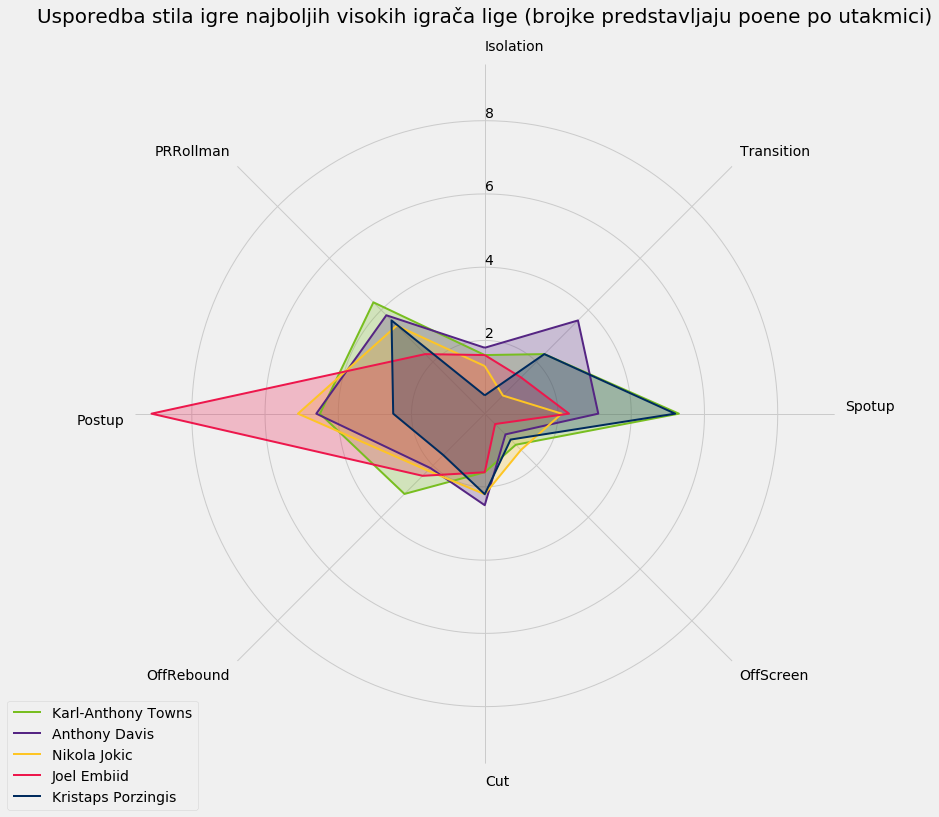

In [45]:
plot_radar(
    title="Usporedba stila igre najboljih visokih igrača lige (brojke predstavljaju poene po utakmici)",
    data=final_data,
    labels=target_players,
    colors=[
        "#78BE20", ## minny
        "#552583", ## lakers
        "#FEC524", ## denver
        "#ED174C", ## phila
        "#002B5E", ## dallas,
    ],
    alphas=[0.25] * len(target_players)
)

### Asistencije

In [22]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False, zorder=None):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False, zorder=zorder)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color, zorder=zorder)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=zorder)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=zorder)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=zorder)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=zorder)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=zorder)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=zorder)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=zorder)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=7)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=zorder)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=zorder)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None, zorder=7)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [42]:
def plot_raw_shotchart(data_frame, title, ax=None, mode="dark", plot_fg_made = False, percentage=True):
    plt.style.use('fivethirtyeight')
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 14))
    
    #made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    #created_shots = data_frame.loc[data_frame.ACTION_TYPE.isin(created)]
    #catch_and_shoot = data_frame.loc[data_frame.ACTION_TYPE.isin(non_created)]
    yellow = '#FFCD00'
    
    paths = ax.scatter(
        x=data_frame.LOC_X,
        y=data_frame.LOC_Y,
        marker='o',
        c="#E03A3E",
        edgecolors='black',
        s=180,
        alpha=0.95,
        label='Asistiran šut'
    )
    
    """paths = ax.scatter(
        x=created_shots.LOC_X,
        y=created_shots.LOC_Y,
        marker='o',
        c=yellow,
        edgecolors='black',
        s=180,
        alpha=0.95,
        label='"Created" shots'
    )
    """
    
    if mode == 'dark':
        background_color="#232323"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
        
    if plot_fg_made:
        original_df = data_frame
        df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).sum()
        df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
        df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).median()
        for index in range(len(df_by_zone_median)):
            loc_x = df_by_zone_median.iloc[index].LOC_X
            loc_y = df_by_zone_median.iloc[index].LOC_Y
            zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
            zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
            zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
            if zone_shots_attempted < 5:
                continue
            if not percentage:
                ax.text(x=loc_x, y=loc_y+10, s=f"{int(zone_shots_made)}", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})
            else:
                ax.text(x=loc_x, y=loc_y+10, s=f"{float(zone_shots_made) / len(data_frame) * 100:.2f}%", ha='center', c='black',
                       bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'})
    
    
    ax.text(x=245, y=380, s=f"Broj u kvadratićima predstavlja\npostotak ukupnih asistencija", c='black',
                   bbox={'facecolor': '#f0f0f0', 'alpha': 0.75, 'edgecolor': '#e0e0e0'}, ha='right')
    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    team_id = data_frame.iloc[0].TEAM_ID
    player_id = data_frame.iloc[0].PLAYER2_ID
    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # 140, 102
    ax.imshow(img, extent=(112, 252, -47, 55), zorder=7)
    # Legend

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.grid(False)

    # Title
    ax.set_title(title, size=20)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, background_color=background_color)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)

    
    ax.legend(loc='upper right')
    

### Loading and plotting

In [24]:
pbp_df = pd.read_csv('../../2019_20_season/play_by_plays/full_pbp_2019_20_dropped.csv')


pbp_df.loc[:, "GAME_ID_STR"] = ["00" + str(item) for item in pbp_df.GAME_ID.tolist()]

In [25]:
all_shots = ShotChartDetail(team_id=0, player_id=0, season_nullable='2019-20')

In [26]:
all_df = all_shots.get_data_frames()[0]

In [28]:
philly_id = find_teams_by_full_name("Philadelphia 76ers")[0]['id']

In [32]:
simmons_id = find_players_by_full_name("Ben Simmons")[0]['id']

In [40]:

shot_df = all_df.loc[all_df.TEAM_ID == philly_id]

#shot_df = shot_df.get_data_frames()[0]
df_merged = pd.merge(left=pbp_df, right=shot_df, left_on=('GAME_ID_STR', 'EVENTNUM'), right_on=('GAME_ID', 'GAME_EVENT_ID'))

In [33]:
player_assists = df_merged.loc[df_merged.PLAYER2_ID == simmons_id]

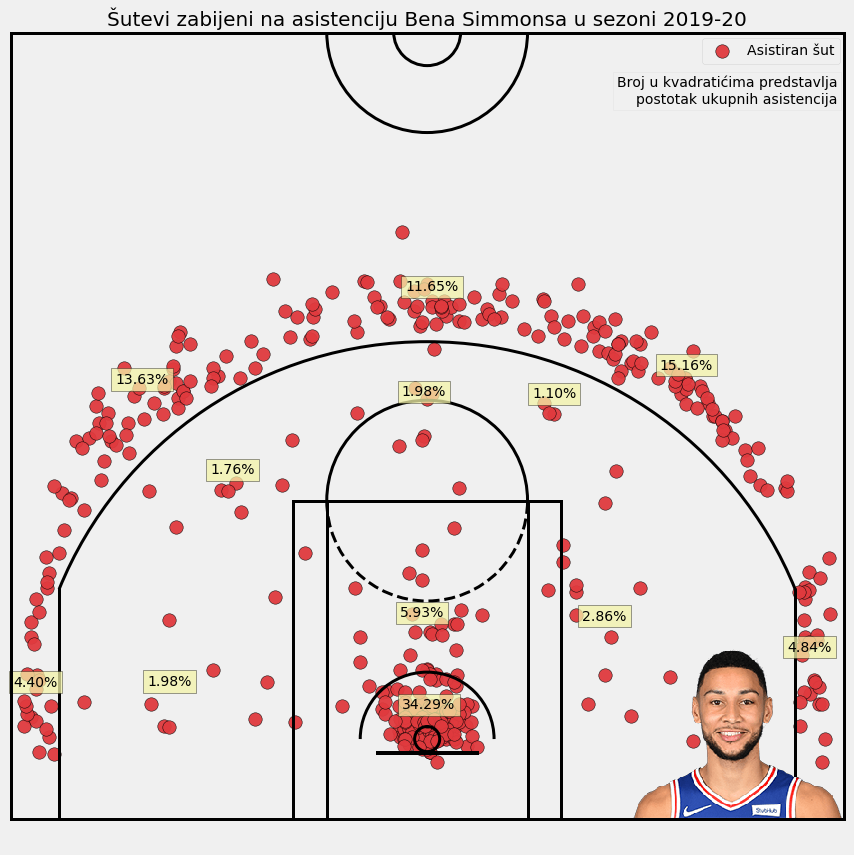

In [36]:
plot_raw_shotchart(data_frame=player_assists, title='Šutevi zabijeni na asistenciju Bena Simmonsa u sezoni 2019-20', mode='light', plot_fg_made=True)

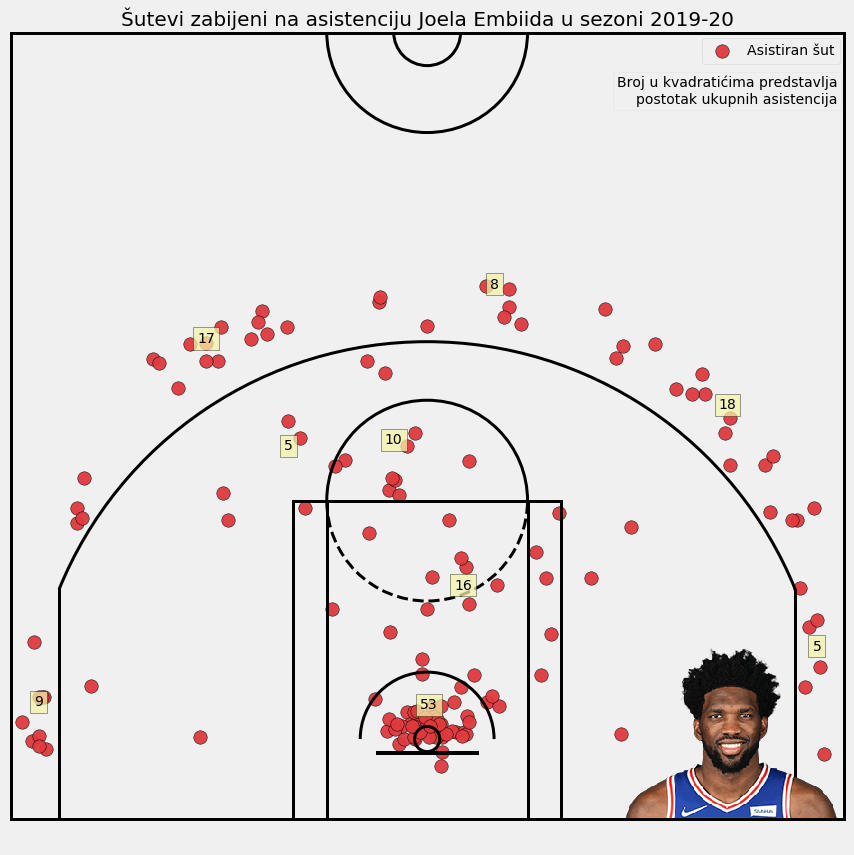

In [43]:
player_assists = df_merged.loc[df_merged.PLAYER2_ID == target_players_ids['Joel Embiid']]
plot_raw_shotchart(data_frame=player_assists, title='Šutevi zabijeni na asistenciju Joela Embiida u sezoni 2019-20', mode='light', plot_fg_made=True, percentage=False)

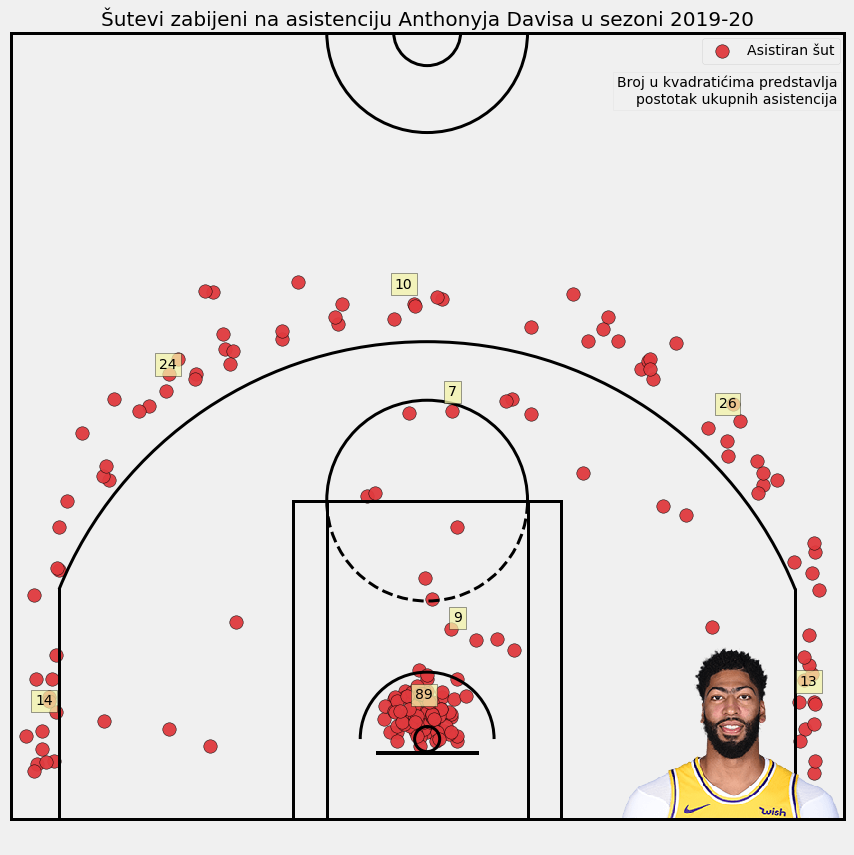

In [44]:

shot_df = all_df.loc[all_df.TEAM_ID == find_teams_by_full_name("Los Angeles Lakers")[0]['id']]

#shot_df = shot_df.get_data_frames()[0]
df_merged = pd.merge(left=pbp_df, right=shot_df, left_on=('GAME_ID_STR', 'EVENTNUM'), right_on=('GAME_ID', 'GAME_EVENT_ID'))
player_assists = df_merged.loc[df_merged.PLAYER2_ID == target_players_ids['Anthony Davis']]
plot_raw_shotchart(data_frame=player_assists, title='Šutevi zabijeni na asistenciju Anthonyja Davisa u sezoni 2019-20', mode='light', plot_fg_made=True, percentage=False)